# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import numpy as np
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

Загрузим данные

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [4]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [5]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Проверим данные на пропуски

In [6]:
df_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
df_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
df_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
def plot3d(df):
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(projection='3d')

    n = 100
    xs = df['f0']
    ys = df['f1']
    zs = df['f2']
    ax.scatter(xs, ys, zs, color = "green", alpha = 0.1, marker = '.')

    ax.set_xlabel('f0')
    ax.set_ylabel('f1')
    ax.set_zlabel('f2')
    plt.title("Пространство признаков")

    plt.show()

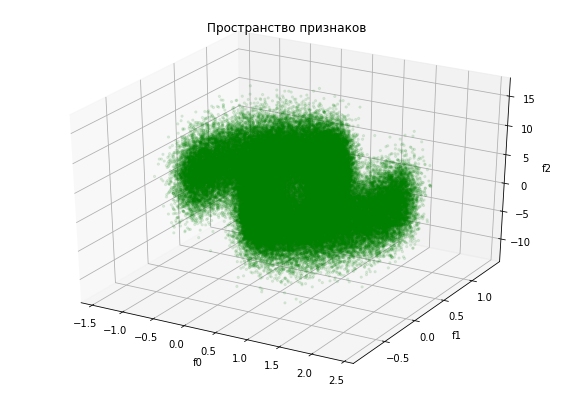

In [10]:
plot3d(df_0)

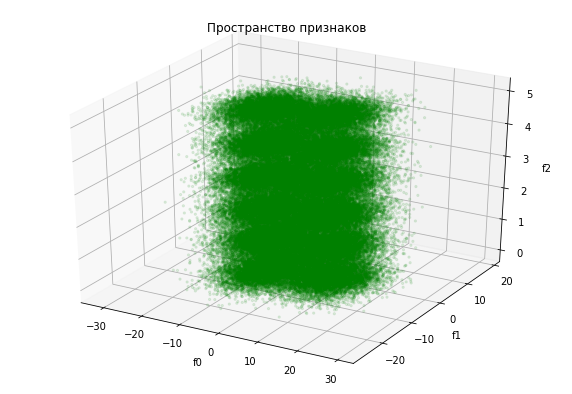

In [11]:
plot3d(df_1)

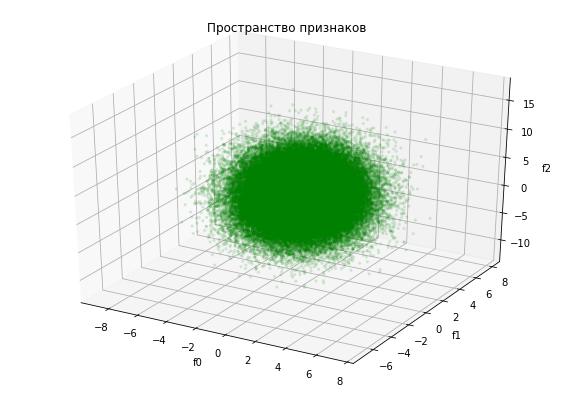

In [12]:
plot3d(df_2)

Пропусков нет, тип данных int64

## Обучение и проверка модели

Напишем функцию, которая:
- разделит выборку на признаки и целевой признак <br>
- выделит валидационную выборку (75:25)
- обучит модель и сделает предсказания на валидационной выборке (lr)
- сохранит предсказания и правильные ответы на валидационной выборке (predicted_valid, target_valid)
- напечатает на экране средний запас предсказанного сырья и RMSE модели

In [13]:
def region_model(df):
    target = df['product']
    features = df.drop(['product', 'id'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=17)
    lr = LinearRegression().fit(features_train, target_train)
    predicted_valid = lr.predict(features_valid)
    print(f'Среднее значение по запасам в регионе: {predicted_valid.mean()}')
    mse = mean_squared_error(target_valid, predicted_valid)
    print("Linear Regression")
    print("MSE =", mse)
    print("RMSE =", mse ** 0.5)
    return predicted_valid.mean()

In [14]:
region_model(df_0)

Среднее значение по запасам в регионе: 92.39061493772542
Linear Regression
MSE = 1427.781491940549
RMSE = 37.785995976559214


92.39061493772542

In [15]:
region_model(df_1)

Среднее значение по запасам в регионе: 68.8193838168864
Linear Regression
MSE = 0.7863522731454989
RMSE = 0.8867650608506736


68.8193838168864

In [16]:
region_model(df_2)

Среднее значение по запасам в регионе: 95.08577045778986
Linear Regression
MSE = 1611.4625738615694
RMSE = 40.1430264661444


95.08577045778986

Наименьшая ошибка RMSE на датафрейме df_1, модель дает наиболее точные предсказания.
Среднее значение запасов в этом регионе наименьшее. Модели df_0 и df_2 судя по RMSE переоценивают количество запасов.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбираем регион с наибольшей средней прибылью.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [17]:
n_oil_well = 200
expences = 10000000000
one_oil_well_expences = expences/n_oil_well
barrel_cost_k = 450000
v_oil_min = one_oil_well_expences/barrel_cost_k
print(f' {v_oil_min}')

 111.11111111111111


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [18]:
for x in [df_0, df_1, df_2]:
    print(region_model(x) - v_oil_min)

Среднее значение по запасам в регионе: 92.39061493772542
Linear Regression
MSE = 1427.781491940549
RMSE = 37.785995976559214
-18.720496173385698
Среднее значение по запасам в регионе: 68.8193838168864
Linear Regression
MSE = 0.7863522731454989
RMSE = 0.8867650608506736
-42.291727294224714
Среднее значение по запасам в регионе: 95.08577045778986
Linear Regression
MSE = 1611.4625738615694
RMSE = 40.1430264661444
-16.02534065332125


В среднем запасов в регионе меньше, чем нужно для безубытка, но если отбирать лучшие, то возможно прибыль получить можно

Напишем класс с методами для:
- подготовки выборок (split_df) возвращает разделенные на train, valid выборки
- предсказаний результата после обучения (predict_model)
- расчета mse (predict_mse)

In [19]:
class RegionModel:
    def __init__(self,df):
        self.df=df
        
    @classmethod
    def split_df(self, df):
        target = df['product']
        features = df.drop(['product', 'id'] , axis=1)
        features_train, features_valid, target_train, target_valid = train_test_split(
            features,
            target,
            test_size=0.25,
            random_state=17)
        return features_train, features_valid, target_train, target_valid
    
    @classmethod
    def predict_model(cls, df):
        features_train, features_valid, target_train, target_valid = cls.split_df(df)
        lr = LinearRegression().fit(features_train, target_train)
        predicted_valid = lr.predict(features_valid)
        return predicted_valid
    
    @classmethod
    def predict_mse(cls, df):
        features_train, features_valid, target_train, target_valid = cls.split_df(df)
        lr = LinearRegression().fit(features_train, target_train)
        predicted_valid = lr.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted_valid)
        return mse


Построим графики распределения частоты предсказанных запасов по регионам

(array([  2.,   0.,   2.,   2.,   2.,   0.,   6.,   5.,   6.,   2.,   8.,
         13.,  12.,  14.,  19.,  18.,  22.,  33.,  30.,  57.,  50.,  60.,
         76., 110., 124., 130., 161., 159., 196., 194., 235., 227., 287.,
        321., 339., 361., 402., 370., 466., 501., 569., 534., 614., 605.,
        629., 632., 694., 679., 761., 717., 724., 717., 703., 740., 692.,
        658., 702., 690., 654., 637., 563., 564., 547., 507., 439., 477.,
        391., 360., 326., 307., 268., 239., 218., 195., 182., 139., 151.,
        128., 115., 111.,  77.,  51.,  49.,  39.,  37.,  29.,  26.,  13.,
         14.,  17.,  11.,  13.,   5.,   4.,   3.,   5.,   4.,   0.,   2.,
          1.]),
 array([  4.40077192,   6.11259259,   7.82441327,   9.53623395,
         11.24805462,  12.9598753 ,  14.67169598,  16.38351665,
         18.09533733,  19.807158  ,  21.51897868,  23.23079936,
         24.94262003,  26.65444071,  28.36626139,  30.07808206,
         31.78990274,  33.50172342,  35.21354409,  36.92536477

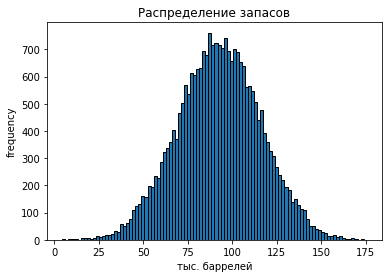

In [20]:
model = RegionModel(df_0)
wells = model.predict_model(df_0)
plt.title('Распределение запасов')
plt.ylabel('frequency')
plt.xlabel('тыс. баррелей')
plt.hist(wells, bins=100, edgecolor='k')

(array([1.514e+03, 2.400e+03, 1.800e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.910e+02, 2.532e+03, 1.507e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.600e+03, 2.476e+03, 1.440e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02, 2.618e+03,
        1.392e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.510e+03, 2.459e+03, 1.420e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.240e+02,
        2.484e+03, 1.393e+03]),
 array([ -1.92088082,   0.91730188,   3.75548459,   6.5936673 ,
          9.43185   ,  12.27003271,  15.10821541,  17.94639812,
         20.78458083,  23.62276353,  26.46094624,  29.29912895,
         32.13731165,  34.97549436,  37.81367706,  40.65185977,
         43.49004248,  46.32822518,  49.16640789,  52.00459059,
         54.8427733 ,  57.68095601,  60.51913871,  63.35

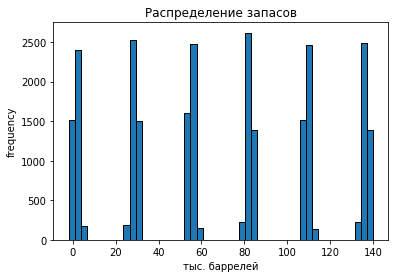

In [21]:
model = RegionModel(df_1)
wells = model.predict_model(df_1)
plt.title('Распределение запасов')
plt.ylabel('frequency')
plt.xlabel('тыс. баррелей')
plt.hist(wells, bins=50, edgecolor='k')

(array([  1.,   2.,   0.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   4.,
          4.,   4.,   3.,   9.,   6.,  16.,  23.,  25.,  36.,  31.,  43.,
         54.,  71.,  92.,  99., 117., 111., 148., 186., 215., 229., 276.,
        278., 325., 398., 420., 414., 500., 521., 575., 569., 579., 626.,
        671., 756., 735., 787., 833., 779., 808., 835., 833., 796., 763.,
        780., 682., 685., 669., 599., 620., 553., 537., 492., 459., 413.,
        362., 341., 314., 298., 247., 202., 192., 176., 125., 101.,  99.,
         75.,  68.,  62.,  53.,  36.,  32.,  27.,  27.,  15.,  13.,   8.,
          4.,   7.,   6.,   2.,   5.,   1.,   1.,   0.,   0.,   0.,   1.,
          1.]),
 array([ 12.22072382,  13.84141816,  15.46211249,  17.08280683,
         18.70350116,  20.3241955 ,  21.94488983,  23.56558417,
         25.1862785 ,  26.80697284,  28.42766717,  30.0483615 ,
         31.66905584,  33.28975017,  34.91044451,  36.53113884,
         38.15183318,  39.77252751,  41.39322185,  43.01391618

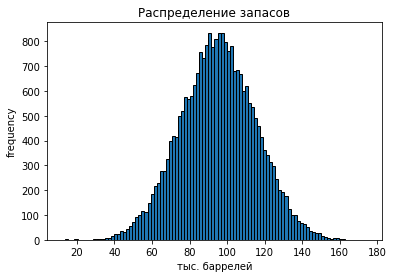

In [22]:
model = RegionModel(df_2)
wells = model.predict_model(df_2)
plt.title('Распределение запасов')
plt.ylabel('frequency')
plt.xlabel('тыс. баррелей')
plt.hist(wells,bins=100, edgecolor='k')

## Расчёт прибыли и рисков 

Выберем скважины с максимальными значениями предсказаний

In [23]:
def oil_well_choise(i):
        model = RegionModel(i)
        wells = model.predict_model(i)
        best_wells = wells[wells > v_oil_min]
        return np.sort(best_wells)[-n_oil_well:]
        
best_wells_0 = oil_well_choise(df_0)
best_wells_1 = oil_well_choise(df_1)
best_wells_2 = oil_well_choise(df_2)

Рассчитаем прибыль для полученного объёма сырья в каждом регионе в миллиардах рублей.

In [24]:
def oil_profit(best_wells_final):
    return (best_wells_final.sum()*barrel_cost_k-expences)/1000000000

print(oil_profit(best_wells_0))
print(oil_profit(best_wells_1))
print(oil_profit(best_wells_2)) 

3.923761937651863
2.4884537018915633
3.428633557311424


По максимальным значениям предсказаний, самыми прибыльными являются регионы df_0, df_2

### Посчитаем риски и прибыль для каждого региона:

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
Напишем функцию для расчета:
- средней прибыли
- 95%-й доверительного интервала
- риск убытков

In [25]:
state = np.random.RandomState(12345)

def bootstrap_model(df):
    values = []
    model = RegionModel(df)
    features_train, features_valid, target_train, target_valid = model.split_df(df)
    wells  = model.predict_model(df)
    wells = pd.Series(wells, index=target_valid.index)
    for i in range(1000):
        target_subsample = wells.sample(n=500, replace=True, random_state=state)
        best_wells_n = target_subsample.sort_values(ascending=False)[:n_oil_well]
        target_values = target_valid[best_wells_n.index]
        values.append(oil_profit(target_values))
    values_ser = pd.Series(values)
    lower = values_ser.quantile(0.025)
    upper = values_ser.quantile(0.975)
    #confidence_interval = st.t.interval(alpha=0.95, df=len(values_ser)-1, loc=values_ser.mean(), scale=values_ser.sem())

    mean = values_ser.mean()
    print("Средняя прибыль:", mean)
    print("95%-доверительный интервал:", [lower, upper])
    print("Количество убыточных скважин:",values_ser[values_ser < 0].count())
    return values

In [26]:
bootstrap_model(df_0)

Средняя прибыль: 0.45915237993781466
95%-доверительный интервал: [-0.034024848424327035, 0.9460326520246811]
Количество убыточных скважин: 31


[0.6117321006388188,
 0.5020278807778912,
 0.87327268893433,
 0.6003501371592674,
 0.33807577617396734,
 0.5397312107572098,
 0.48513938920983884,
 0.32101234309365084,
 0.9742903447392063,
 0.48549064204502107,
 0.8979979390106201,
 0.5102372282484131,
 0.432347794094698,
 0.3839512290361881,
 0.8487248863540936,
 0.45039575857427405,
 0.32477040511626815,
 0.3304797491170178,
 0.5698390214294757,
 0.42120843779730227,
 0.03548343945896721,
 0.09722320819249344,
 0.48497071831886485,
 0.4564276629964008,
 0.06419287996222686,
 0.7641550594162368,
 0.8333025803503189,
 0.6458710993803558,
 0.5008138213674317,
 0.39157626714902494,
 0.5421609801332626,
 0.16005141777717208,
 0.4430345989747238,
 0.9986040653595295,
 0.7707710254485683,
 0.20980877346374513,
 0.2632958373255196,
 0.35087106214143754,
 0.48194974079307173,
 0.3641310800667992,
 0.5734554004050407,
 0.3206856936604939,
 0.6046974660711976,
 0.21365650029450417,
 0.7995150300341645,
 0.7271821397848969,
 0.3859482735839386,

In [27]:
bootstrap_model(df_1)

Средняя прибыль: 0.4344743902498418
95%-доверительный интервал: [0.03604881842157416, 0.84163462244749]
Количество убыточных скважин: 16


[0.6004687643719597,
 0.37356377304182814,
 0.2529582965645466,
 0.030407293554895402,
 0.5461683100322647,
 0.6211191089776631,
 1.0591303340178986,
 0.7544755512506351,
 0.5569288811671658,
 0.5719190409562455,
 0.3485594401156464,
 0.38712333666846466,
 0.3935299194828873,
 0.4385003988501244,
 0.2379681367754669,
 0.5961769758846321,
 0.2201789844946537,
 0.682510344296423,
 0.17950029361474037,
 0.41561086025102995,
 0.594746379722187,
 0.523403171099474,
 0.6668359863426971,
 0.45989714145362093,
 0.6860557347859574,
 0.21663359400511742,
 0.6147125261632423,
 0.4192184505737114,
 0.6931465157650242,
 0.36211900374228284,
 0.43420861036279296,
 0.11879325646062851,
 0.29077579511956786,
 0.3585736132527485,
 0.5198577806099396,
 0.5033748248252677,
 0.45062936631431577,
 0.5911387893995018,
 0.2287003616361618,
 0.7516765587588978,
 0.6268414936274376,
 -0.00604180867083168,
 0.30358896074840735,
 0.20089703621824073,
 0.5875933989099693,
 0.03532108037372208,
 0.4284862257130203

In [28]:
bootstrap_model(df_2)

Средняя прибыль: 0.32466956596255664
95%-доверительный интервал: [-0.19856968085540044, 0.8649035020278184]
Количество убыточных скважин: 120


[0.4831995265115643,
 0.4213986363471699,
 -0.03716143693528938,
 0.31124039413768007,
 0.5079215019223347,
 -0.02802754630999756,
 0.20767828352224924,
 0.09446335555518913,
 0.355627479564476,
 0.1768666455999012,
 0.5139458548271504,
 0.17370480264806556,
 0.04386604429289818,
 -0.06846283559000588,
 0.49180367933759117,
 -0.008566022168207168,
 0.15620317642868806,
 -0.011398223379587173,
 0.5851221178738288,
 0.12912677901851846,
 -0.11236755841032028,
 0.287093794304554,
 -0.5514779705783787,
 0.5820448239852162,
 -0.13195332649416353,
 0.5192560548955212,
 0.1689080401229992,
 0.31527676093219564,
 0.8572772065947933,
 0.5631099254575215,
 -0.26671188414472197,
 0.4185149081004486,
 0.4402799072382984,
 0.16786368083485795,
 0.19133226292611885,
 -0.13077953013220978,
 0.5896113341279411,
 0.6873541544593181,
 0.33717704585827635,
 0.41112776987436295,
 0.12488596553673363,
 0.3108838301318207,
 0.4862537473974247,
 0.45579207815538786,
 0.3125556987870655,
 -0.19119166976496504

К разработке рекомендуется регион df_1 он второй по средней прибыли, в доверительном интервале нет отрицательной прибыли, риск убытков самый низкий. RMSE самый низкий, те предсказания самые точные.

In [29]:
st.ttest_ind(bootstrap_model(df_0), bootstrap_model(df_1))

Средняя прибыль: 0.46349197304712947
95%-доверительный интервал: [-0.04422241484067911, 0.9538423270104485]
Количество убыточных скважин: 37
Средняя прибыль: 0.4328706297519098
95%-доверительный интервал: [0.025023897995788826, 0.8182023903041669]
Количество убыточных скважин: 20


Ttest_indResult(statistic=2.9247161598691793, pvalue=0.00348654999580516)

In [30]:
st.ttest_ind(bootstrap_model(df_2), bootstrap_model(df_1))

Средняя прибыль: 0.3333985086320265
95%-доверительный интервал: [-0.19662193905492623, 0.8368250357221655]
Количество убыточных скважин: 107
Средняя прибыль: 0.4369768761369541
95%-доверительный интервал: [0.04879356423394895, 0.8393969834499315]
Количество убыточных скважин: 14


Ttest_indResult(statistic=-9.543047395445251, pvalue=3.882731854472854e-21)

In [31]:
st.ttest_ind(bootstrap_model(df_0), bootstrap_model(df_2))

Средняя прибыль: 0.4511174550479635
95%-доверительный интервал: [-0.0509050651717802, 0.9594695228608405]
Количество убыточных скважин: 43
Средняя прибыль: 0.3295544733086193
95%-доверительный интервал: [-0.20818670917954257, 0.8373534133720728]
Количество убыточных скважин: 96


Ttest_indResult(statistic=10.473549323305514, pvalue=5.016622864373282e-25)

p-value много меньше alpha=0.05.
Средние выручки по регионам имеют статистически значимые отличия